In [1]:
import json
import pandas as pd
import spacy
import numpy as np
from collections import Counter
from nltk import sent_tokenize, word_tokenize
import sklearn
from sklearn.metrics import pairwise_distances 
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from pyemd import emd
from sklearn.preprocessing import normalize
from surprise import accuracy, SVD
import matplotlib.pyplot as plt
import os
from surprise import Reader
from surprise import Dataset
import plotly
plotly.offline.init_notebook_mode(connected=False)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [2]:
with open('data/squad/train-v1.1.json') as json_data:
    train_data = json.load(json_data)
with open('data/squad/dev-v1.1.json') as json_data:
    dev_data = json.load(json_data)

In [3]:
train_data['data'].extend(dev_data['data'])

In [4]:
def preprocessing(train_data):
    ques = []
    ans = []
    context = []
    for data_index, data_paragraph in enumerate(train_data['data']):
            for each_paragraph in data_paragraph['paragraphs']:
                question_data = each_paragraph['qas']
                context_data = each_paragraph['context']
                for number_of_question in range(len(question_data)):
                        question = question_data[number_of_question]['question']
                        start_index = question_data[number_of_question]['answers'][0]['answer_start']
                        answer = question_data[number_of_question]['answers'][0]['text']
                        end_index = start_index + len(answer)
                        full_stop = []
                        for pos,char in zip(range(len(context_data)),context_data):
                            if char == '.':
                                full_stop.append(pos)
                        full_stop.append(start_index)
                        full_stop = sorted(full_stop)
                        for pos,value in enumerate(full_stop):
                            if value == start_index:
                                if pos == 0:
                                    answer_start = pos
                                else:
                                    answer_start = full_stop[pos - 1] + 2
                                if pos == len(full_stop) - 1:
                                    answer_stop = pos
                                else:
                                    answer_stop = full_stop[pos + 1] 
                        ques.append(question)
                        ans.append(context_data[answer_start:answer_stop])
                        context.append(context_data)
    ques_ans_data = pd.DataFrame({'context':context,'question':ques,'answer':ans})
    return ques_ans_data

In [5]:
ques_ans_data_start = preprocessing(train_data)

In [6]:
def get_word_counter():
    word_counter = {}
    for answer, question in zip(ques_ans_data_start['answer'], ques_ans_data_start['question']):
        ans_list, ques_list = word_tokenize(answer), word_tokenize(question)
        for a in ans_list:
            word_counter[a.lower()] = word_counter.get(a.lower(), 0) + 1
        for q in ques_list:
            word_counter[q.lower()] = word_counter.get(q.lower(), 0) + 1
            
    return word_counter        

In [7]:
word_counter = get_word_counter()

In [8]:
def get_word2vec():
    word2vec_dict = {}
    word_counter = get_word_counter()
    with open('data/glove/glove.6B.100d.txt','r',encoding = 'utf-8') as glove_data:
        for line in glove_data:
            array = line.lstrip().rstrip().split(" ")
            word = array[0]
            vector = list(map(float, array[1:]))
            if word in word_counter.keys():
                word2vec_dict[word] = vector
            elif word.capitalize() in word_counter.keys():
                word2vec_dict[word.capitalize()] = vector
            elif word.lower() in word_counter.keys():
                word2vec_dict[word.lower()] = vector
            elif word.upper() in word_counter.keys():
                word2vec_dict[word.upper()] = vector
    return word2vec_dict

In [9]:
word2vec_dict = get_word2vec()

In [10]:
#function which calculates euclidean distance between each word of ques and answer
def get_similarity(question, answer):
    distance_list = []
    for each_answer_word in word_tokenize(answer.lower()):
        
        each_word_dist = []
        for each_ques_word in word_tokenize(question.lower()):
            if each_answer_word in word2vec_dict.keys() and each_ques_word in word2vec_dict.keys():
                word2vec_answer = word2vec_dict[each_answer_word]
                word2vec_question = word2vec_dict[each_ques_word]
                word2vec_answer = np.array(word2vec_answer).reshape((1,100))
                word2vec_question = np.array(word2vec_question).reshape((1,100))
            else:
                word2vec_answer = np.random.random((1,100))
                word2vec_question = np.random.random((1,100))
            dist = pairwise_distances(word2vec_answer, word2vec_question)
            each_word_dist.append(dist[0][0])
        distance_list.append(each_word_dist)    
#     trace = go.Heatmap(z=distance_list,
#                    x=word_tokenize(question),
#                    y=word_tokenize(answer))
#     data=[trace]
#     plot(data, filename='labelled-heatmap')
    return distance_list

In [11]:
#function to calculate emd based on glove vectors
def get_emd(user_question, sent1):
    unique_words_in_ques_sent = list(set(word_tokenize(user_question) + word_tokenize(sent1)))
    left_vector_dict = {}
    right_vector_dict = {}
    
    for w in unique_words_in_ques_sent:
        
        if w in word_tokenize(user_question):
            left_vector_dict[w] = left_vector_dict.get(w, 0) + 1
            
        else:
            left_vector_dict[w] = 0
            
    for w in unique_words_in_ques_sent:
        
        if w in word_tokenize(sent1):
            right_vector_dict[w] = right_vector_dict.get(w, 0) + 1
        else:
            right_vector_dict[w] = 0
            
    left_vector = [left_vector_dict[key] for key in sorted(left_vector_dict)]
    right_vector = [right_vector_dict[key] for key in sorted(right_vector_dict)]  
    sent_words_in_qa = ' '.join([word for word in unique_words_in_ques_sent])
    qa_distance = np.array(get_similarity(sent_words_in_qa, sent_words_in_qa))
    emd_dist = emd(np.array(left_vector, dtype=np.float)/sum(np.array(left_vector, dtype=np.float)),
    np.array(right_vector, dtype=np.float)/sum(np.array(right_vector, dtype=np.float)), qa_distance)
    return emd_dist


In [12]:
def get_answer_ner_tags():
    nlp = spacy.load('en')
    all_answer_ner = []
    all_ner_list = []
    unique_ner_list = []
    unique_ner = set()

    for each_answer in ques_ans_data_start['answer']:
        nlp_answer = nlp(each_answer)
        ner = {}
        for each_word in nlp_answer.ents:
            if each_word.label_ == 'GPE' or each_word.label_ == 'FAC':
                ner['PLACE'] = ner.get('PLACE', 0) + 1
                unique_ner_list.append('PLACE')
            elif each_word.label_ == 'CARDINAL' or each_word.label_ == 'ORDINAL':
                ner['NUMBER'] = ner.get('NUMBER', 0) + 1
                unique_ner_list.append('NUMBER')

            else:   
                ner[each_word.label_] = ner.get(each_word.label_, 0) + 1
                unique_ner_list.append(each_word.label_)

        all_answer_ner.append(ner) 
        all_ner_list.append(ner.keys())
        unique_ner = set(unique_ner_list)  
    return all_ner_list, unique_ner, all_answer_ner

In [13]:
all_ner_list, unique_ner, all_answer_ner = get_answer_ner_tags()

In [14]:
def getting_question_type():
    question_type = []
    ques_ans_token = []
    ques_types = ["how", "which", "where", "what", "when", "who", "how long", "how big", "how heavy", "how much", \
         "how many", "how high", "what date", "what year", "what state", "what country", "how old"]
    for ques in ques_ans_data_start['question']:
        quest_type = "others"
        for q_type in ques_types:
            if q_type in ques.lower():
                quest_type = q_type
        question_type.append(quest_type)
    tokens = pd.DataFrame({'ques_type': question_type}) 
    return tokens

In [15]:
tokens = getting_question_type()

In [16]:
answer_tag = pd.DataFrame({'answer_tags': all_ner_list})
answer_tag_freq = pd.DataFrame({'answer_tags_freq': all_answer_ner})
ques_ans_data = pd.concat([ques_ans_data_start, tokens, answer_tag, answer_tag_freq], axis=1)

In [17]:
unique_questions = pd.unique(ques_ans_data['ques_type'])

In [18]:
def get_question_ner_tags():
    ques_ner_dict = {}
    ques_ner_freq_dict = {}
    for ques_type in unique_questions:

        ques_df = ques_ans_data[ques_ans_data.ques_type == ques_type]
        ques_tag_dict = {}
        ques_tag_dict_freq = {}
        ques_tag_dict_freq_counter = Counter()
        for atag_list in ques_df['answer_tags']:
            for tag in atag_list:
                ques_tag_dict[tag] = ques_tag_dict.get(tag, 0) + 1

        for dict in list(ques_df['answer_tags_freq']):
            ques_tag_dict_freq_counter += Counter(dict)
                
        ques_ner_dict[ques_type] = ques_tag_dict
        ques_ner_freq_dict[ques_type] = ques_tag_dict_freq_counter
        
    return ques_ner_dict, ques_ner_freq_dict      

In [19]:
ques_ner_dict, ques_ner_freq_dict = get_question_ner_tags()

In [20]:
unique_ner = list(unique_ner)

In [22]:
def plot_ques_ner(ques_ner_freq_dict):
    plot_list = []
    
    for uq in unique_questions:
        sub_list = []
        for utag in unique_ner:
            sub_list.append(ques_ner_dict[uq].get(utag, 0))
        plot_list.append(np.array(sub_list)/np.sum(np.array(sub_list)))  
#     trace = go.Heatmap(z=plot_list,
#                x=unique_ner,
#                y=unique_questions)
#     data=[trace]
#     plot(data, filename='labelled-heatmap.html')
    return plot_list

        

In [23]:
def plot_ques_ner_without_normalization(ques_ner_freq_dict):
    plot_list = []
    
    for uq in unique_questions:
        sub_list = []
        for utag in unique_ner:
            sub_list.append(ques_ner_freq_dict[uq].get(utag, 0))
        plot_list.append(sub_list)  
#     trace = go.Heatmap(z=plot_list,
#                x=unique_ner,
#                y=unique_questions)
#     data=[trace]
#     plot(data, filename='labelled-heatmap.html')
    return plot_list

        

In [24]:
ques_ner_similarity_mat = plot_ques_ner_without_normalization(ques_ner_freq_dict)

In [25]:
unique_ques_sent_tags = list(unique_questions) + unique_ner

In [26]:
ques_ner_sim_log_mat = pd.DataFrame(np.log(np.array(ques_ner_similarity_mat) + 1))

In [27]:
x1 = []
x2 = []
o = []
for index in ques_ner_sim_log_mat.index:
    for value,ner in zip(ques_ner_sim_log_mat.iloc[index],ques_ner_sim_log_mat.columns):
        o.append(value)
        x1.append(index)
        x2.append(ner)

In [28]:
dataframe_to_svd = pd.DataFrame({'x1': x1, 'x2': x2, 'y': o})

In [29]:
dataframe_to_svd.to_csv(path_or_buf='que_ne_occ.csv', sep=',', index=False, header=False)

In [30]:
file_path = os.path.expanduser('./que_ne_occ.csv')

In [31]:
reader = Reader(line_format='user item rating', sep=',', rating_scale=(0, 25))
data = Dataset.load_from_file('que_ne_occ.csv', reader=reader)

RMSE: 0.8914
RMSE: 0.9246
RMSE: 0.6399
RMSE: 0.8260
RMSE: 0.8258


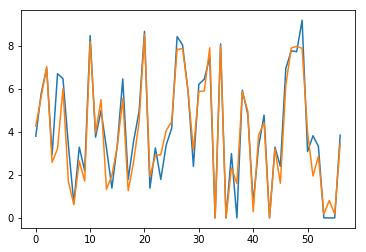

In [32]:
algo = SVD(n_factors=5,n_epochs=1000,init_mean=5)

for trainset, testset in data.folds():
    algo.train(trainset)
    predictions_svd = algo.test(testset)
    rmse = accuracy.rmse(predictions_svd, verbose=True)
svd_df = pd.DataFrame(predictions_svd)
svd_df['error'] = svd_df.est - svd_df.r_ui    
plt.plot(svd_df['r_ui'])
plt.plot(svd_df['est'])
plt.show()

In [33]:
algo_pq = np.append(algo.qi, algo.pu)

In [34]:
algo_pq_distance = algo_pq.reshape(len(unique_ques_sent_tags), 5)

# Weight matrix

In [35]:
tags_weight_matrix = []
for i in algo_pq_distance:
    each_tag_weights = []
    for j in algo_pq_distance:
        dist = pairwise_distances(i.reshape((1,5)), j.reshape((1,5)))
        each_tag_weights.append(dist[0][0])
    tags_weight_matrix.append(each_tag_weights)

In [36]:
np.save('wmd_weight_matrix', np.array(tags_weight_matrix))

# EMD METHOD

In [37]:
def get_emd_with_tags(qtag, atag):
    ques_tagged = {}
    sent_tagged = {}
    for word in unique_ques_sent_tags:
        if word in qtag.keys():
            ques_tagged[word] = 1
        else:
            ques_tagged[word] = 0

        if word in atag.keys():
            sent_tagged[word] = atag[word]
        else:
            sent_tagged[word] = 0
    tag_left_vector = [ques_tagged[key] for key in sorted(ques_tagged)]
    tag_right_vector = [sent_tagged[key] for key in sorted(sent_tagged)]
    tag_right_vector = tag_right_vector/np.sum(tag_right_vector)
    tag_left_vector = np.array(tag_left_vector, dtype=float)
    tag_right_vector = np.array(tag_right_vector, dtype=float)
    emd_score = emd(tag_left_vector,tag_right_vector,np.array(tags_weight_matrix))
    return emd_score

In [38]:
def getting_question_type_user_question(ques):
    question_type = []
    ques_ans_token = []
    ques_types = ["how", "which", "where", "what", "when", "who", "how long", "how big", "how heavy", "how much", \
         "how many", "how high", "what date", "what year", "what state", "what country", "how old"]
    quest_type = "others"
    for q_type in ques_types:
        if q_type in ques.lower():
            quest_type = q_type
    return {quest_type : 1}


In [39]:
def getting_ner_tags_answer(answer):
    ner = {}
    nlp = spacy.load('en')
    doc = nlp(answer)
    for each_word in doc.ents:
        if each_word.label_ == 'GPE' or each_word.label_ == 'FAC':
                ner['PLACE'] = ner.get('PLACE', 0) + 1
        elif each_word.label_ == 'CARDINAL' or each_word.label_ == 'ORDINAL':
            ner['NUMBER'] = ner.get('NUMBER', 0) + 1

        else:   
            ner[each_word.label_] = ner.get(each_word.label_, 0) + 1
    return ner            


In [43]:
def get_wmd_for_tags_test(question, answer):
    qtag = getting_question_type_user_question(question)
    atag = getting_ner_tags_answer(answer)
#     print(atag)
#     trace = go.Heatmap(z=tags_weight_matrix,
#                    x=word_tokenize(answer),
#                    y=unique_questions)
#     data=[trace]
#     plot(data, filename='labelled-heatmap.html')
    emd_val = get_emd_with_tags(qtag, atag)
    return emd_val

In [44]:
question = "Who is the president of U.S.A.?"
answer = "Trump, the president of U.S.A is an 70 years old man"
answer1 = "India is a developing country"
wmd_tags = get_wmd_for_tags_test(question, answer)
wmd_glove = get_emd(question, answer)
print('tags:', wmd_tags)
print('glove:', wmd_glove)
wmd_tags = get_wmd_for_tags_test(question, answer1)
wmd_glove = get_emd(question, answer1)
print('tags:', wmd_tags)
print('glove:', wmd_glove)

tags: 3.0496985990766046
glove: 3.2942095330439436
tags: 3.2648794805408436
glove: 4.474643080499728
